# Train code for Project II 

## Install Packages 

In [ ]:
!pip install antspyx

In [ ]:
!pip insatll SimpleITK

In [ ]:
from numpy import spacing
import ants
import os
import torch
import shutil
import SimpleITK as sitk
import nibabel as nib
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
import time
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import matplotlib
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

## Task A: Skull Stripping

### Clone this repository:

In [ ]:
!git clone https://github.com/MIC-DKFZ/HD-BET.git

### Go into the repository (the folder with the setup.py file) and install:

In [ ]:
!cd HD-BET

In [ ]:
!pip install -e .

### Run your dataset to remove the skull region:

In [ ]:
'''
INPUT_FOLDER: Raw subject folder path (need to remove skull region);
OUTPUT_FOLDER: Skull stripping subject folder path.
'''
!hd-bet -i INPUT_FOLDER -o OUTPUT_FOLDER

## Task B: Registration

### Rigid register T2w to T1w, rigid + nonrigid register FA, ADC to T1w

In [ ]:
from numpy import spacing
import ants
import os
import torch
from sklearn.metrics import mean_absolute_error
import shutil

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in range(164, 201):
  print(i)
  input_path = f"/home/sodgala/Desktop/MIA_Project2/RemovedSkullDataset/{i:03d}"
  output_path = f"/home/sodgala/Desktop/MIA_Project2/RegisteredDataset/{i:03d}"

  if not os.path.exists(output_path):
    os.makedirs(output_path)

  # Define the paths to the input images
  t1_path = f"{input_path}/T1w_1mm.nii.gz"
  t2_path = f"{input_path}/T2w_1mm_noalign.nii.gz"
  fa_path = f"{input_path}/FA_deformed.nii.gz"
  adc_path = f"{input_path}/ADC_deformed.nii.gz"

  # Load the input images using ANTs
  t1 = ants.image_read(t1_path)
  t2 = ants.image_read(t2_path)
  fa = ants.image_read(fa_path)
  adc = ants.image_read(adc_path)

  print(t1)
  print(t2)
  print(fa)
  print(adc)

  # Rigid align T2w, FA, and ADC to T1w using ANTs
  t2_rigid = ants.registration(t1, t2, type_of_transform='Rigid', cost_function='MutualInformation', device=device)
  fa_rigid = ants.registration(t1, fa, type_of_transform='Rigid', cost_function='MutualInformation', device=device)
  adc_rigid = ants.registration(t1, adc, type_of_transform='Rigid', cost_function='MutualInformation', device=device)

  print(t2_rigid)
  print(fa_rigid)
  print(adc_rigid)

  # Save the resulting rigid registered images
  ants.image_write(t2_rigid['warpedmovout'], f"{output_path}/T2w_registered.nii.gz")

  # Non-rigid align FA and ADC to T1w using ANTs
  fa_nonrigid = ants.registration(t1, fa_rigid['warpedmovout'], type_of_transform='SyN', device=device)
  adc_nonrigid = ants.registration(t1, adc_rigid['warpedmovout'], type_of_transform='SyN', device=device)

  # Save the resulting non-rigid registered images
  ants.image_write(fa_nonrigid['warpedmovout'], f"{output_path}/FA_registered.nii.gz")
  ants.image_write(adc_nonrigid['warpedmovout'], f"{output_path}/ADC_registered.nii.gz")
  shutil.copy(t1_path, f"{output_path}/T1w_1mm.nii.gz")


### Padding T1w_1mm, Tw2_registered, FA_registered, ADC_registered from (182, 218, 182) to (192, 224, 192)

In [ ]:
import nibabel as nib
import numpy as np
import os

for i in range(1, 201):
    print(i)
    input_path = f"/home/sodgala/Desktop/MIA_Project2/RegisteredDataset/{i:03d}"
    output_path = f"/home/sodgala/Desktop/MIA_Project2/RegisteredPaddedDataset/{i:03d}"

    if i == 163:
      continue

    if not os.path.exists(output_path):
      os.makedirs(output_path)
    
    # Define the paths to the input images
    t1_path = f"{input_path}/T1w_1mm.nii.gz"
    t2_path = f"{input_path}/T2w_registered.nii.gz"
    fa_path = f"{input_path}/FA_registered.nii.gz"
    adc_path = f"{input_path}/ADC_registered.nii.gz"

    # Load the MRI T1w, FA, and ADC images
    t1w_image = nib.load(t1_path).get_fdata()
    t2w_image = nib.load(t2_path).get_fdata()
    fa_image = nib.load(fa_path).get_fdata()
    adc_image = nib.load(adc_path).get_fdata()

    # Get the current shape of the images
    t1w_shape = t1w_image.shape
    t2w_shape = t2w_image.shape
    fa_shape = fa_image.shape
    adc_shape = adc_image.shape

    # Calculate the amount of padding needed for each dimension
    t1w_padding = tuple((32 - dim % 32) % 32 for dim in t1w_shape)
    t2w_padding = tuple((32 - dim % 32) % 32 for dim in t2w_shape)
    fa_padding = tuple((32 - dim % 32) % 32 for dim in fa_shape)
    adc_padding = tuple((32 - dim % 32) % 32 for dim in adc_shape)

    # Pad the images
    t1w_padded = np.pad(t1w_image, ((0, t1w_padding[0]), (0, t1w_padding[1]), (0, t1w_padding[2])), mode='constant')
    t2w_padded = np.pad(t2w_image, ((0, t2w_padding[0]), (0, t2w_padding[1]), (0, t2w_padding[2])), mode='constant')
    fa_padded = np.pad(fa_image, ((0, fa_padding[0]), (0, fa_padding[1]), (0, fa_padding[2])), mode='constant')
    adc_padded = np.pad(adc_image, ((0, adc_padding[0]), (0, adc_padding[1]), (0, adc_padding[2])), mode='constant')

    # Create new Nifti images with the padded data and affine information
    t1w_padded_nii = nib.Nifti1Image(t1w_padded, nib.load(t1_path).affine)
    t2w_padded_nii = nib.Nifti1Image(t2w_padded, nib.load(t2_path).affine)
    fa_padded_nii = nib.Nifti1Image(fa_padded, nib.load(fa_path).affine)
    adc_padded_nii = nib.Nifti1Image(adc_padded, nib.load(adc_path).affine)

    # Save the padded images in nii.gz format in the patient folder
    nib.save(t1w_padded_nii, f"{output_path}/T1w_1mm_padded.nii.gz")
    nib.save(t2w_padded_nii, f"{output_path}/T2w_registered_padded.nii.gz")
    nib.save(fa_padded_nii, f"{output_path}/FA_registered_padded.nii.gz")
    nib.save(adc_padded_nii, f"{output_path}/ADC_registered_padded.nii.gz")

    # Print the new shape of the images for the current patient
    print('New shape of the T1w image:', t1w_padded.shape)
    print('New shape of the T2w image:', t2w_padded.shape)
    print('New shape of the FA image:', fa_padded.shape)
    print('New shape of the ADC image:', adc_padded.shape)


# Synthesis

### Define functions

In [ ]:
'''image_proc_2C is for generating 2-channel source images pair (T1w, T2w) as the input to the network.'''
def image_proc_2C(filepath1, filepath2):
    """ Data loader (*.nii)
    :param filepath1: file path to the first set of images
    :param filepath2: file path to the second set of images
    :return: 2D array images with 2 channels
    """
    img_data0 = []
    img_data1 = []

    for item1, item2 in tqdm(zip(sorted(filepath1), sorted(filepath2)), desc='Processing'):
        # loading images
        img1 = nib.load(item1).get_fdata()
        img2 = nib.load(item2).get_fdata()

        # stack the two images along the last axis to create a 2-channel image
        combined_img = np.stack((img1, img2), axis=-1)
        
        img_data0.append(combined_img)

    img_data0 = np.concatenate(img_data0, axis=2)
    img_data0 = np.moveaxis(img_data0, [2], [0])
    return np.array(img_data0).astype('float32')

'''image_proc is for generating 1-channel target images (FA/ADC) as the input to the network.'''
def image_proc(filepath):
    """ Data loader (*.nii)
    :param filepath: file path
    :return: 2D array images
    """
    img_data0 = []
    for item in tqdm(sorted(filepath), desc='Processing'):
        # loading images
        img = nib.load(item).get_fdata()
        
        print(img.shape)

        img_data0.append(img)

    img_data0 = np.concatenate(img_data0, axis=2)
    img_data0 = np.moveaxis(img_data0, [2], [0])
    return np.array(img_data0).astype('float32')


def plot_learning_curve(filepath):
    df = pd.read_csv(filepath)
    df_x, df_yt, df_yv = df.values[:, 0], df.values[:, 2], df.values[:, 5]
    plt.figure(figsize=(5, 4))
    plt.plot(df_x, df_yt)
    plt.plot(df_x, df_yv)
    plt.ylabel('mean-squared error', fontsize=16)
    plt.xlabel('epoch', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(['training loss', 'validation loss'], fontsize=14, loc='upper right')
    plt.show()
    return

## FA

### Generate 2D image pairs input from T1w and T2w 3D images

In [ ]:
!pip install SimpleITK

In [ ]:
import numpy as np
import nibabel as nib
import glob
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import SimpleITK as sitk
import os
from torch.utils.data import Dataset, DataLoader

# ... existing data loading and processing code ...

import numpy as np
import nibabel as nib
import glob
from tqdm import tqdm
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import SimpleITK as sitk
import os

# Read and process the images 
# Source image pairs
dataset_path = '/home/sodgala/Desktop/MIA_Project2/RegisteredPaddedDataset/'
# dir_list_sc = sorted(glob.glob(dataset_path + '/MR_images_T1/train-pats/*nii.gz'))
dir_list_sc_t1 = sorted(glob.glob(os.path.join(dataset_path, '*', 'T1w_1mm_padded.nii.gz')))[:180]
dir_list_sc_t2 = sorted(glob.glob(os.path.join(dataset_path, '*', 'T2w_registered_padded.nii.gz')))[:180]
img_sc = image_proc_2C(dir_list_sc_t1, dir_list_sc_t2)

# Target images
# dir_list_tg = sorted(glob.glob(dataset_path + '/MR_images_T2/train-pats/*nii.gz'))
dir_list_tg = sorted(glob.glob(os.path.join(dataset_path, '*', 'FA_registered_padded.nii.gz')))[:180]
img_tg = image_proc(dir_list_tg)

# Rearrange the axes
print(img_sc.shape)
print(img_tg.shape)
img_sc = np.transpose(img_sc, (0, 3, 1, 2))

img_tg = np.expand_dims(img_tg, -1)
img_tg = np.transpose(img_tg, (0, 3, 1, 2))
print(img_sc.shape)
print(img_tg.shape)

# img_sc = np.expand_dims(img_sc, -1)


# Split data to training and validation sets
x_train, x_test, y_train, y_test = train_test_split(img_sc.astype('float32'), img_tg.astype('float32'), test_size=0.20, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=1)

class MRIDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = MRIDataset(x_train, y_train)
val_dataset = MRIDataset(x_val, y_val)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Processing: 180it [00:43,  4.15it/s]
Processing:   1%|          | 2/180 [00:00<00:20,  8.83it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:   3%|▎         | 5/180 [00:00<00:17,  9.75it/s]

(192, 224, 192)
(192, 224, 192)


Processing:   4%|▍         | 7/180 [00:00<00:17,  9.70it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:   6%|▌         | 10/180 [00:01<00:17,  9.72it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:   8%|▊         | 14/180 [00:01<00:16, 10.07it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:   9%|▉         | 16/180 [00:01<00:16,  9.98it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  11%|█         | 19/180 [00:01<00:16,  9.85it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  12%|█▏        | 21/180 [00:02<00:16,  9.80it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  13%|█▎        | 24/180 [00:02<00:15,  9.90it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  14%|█▍        | 26/180 [00:02<00:15,  9.70it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  16%|█▌        | 28/180 [00:02<00:15,  9.69it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  17%|█▋        | 31/180 [00:03<00:15,  9.92it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  18%|█▊        | 33/180 [00:03<00:15,  9.73it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  19%|█▉        | 35/180 [00:03<00:15,  9.49it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  21%|██        | 38/180 [00:03<00:14,  9.80it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  22%|██▏       | 39/180 [00:03<00:14,  9.82it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  24%|██▍       | 44/180 [00:04<00:13,  9.88it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  26%|██▌       | 46/180 [00:04<00:13, 10.15it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  28%|██▊       | 50/180 [00:05<00:13,  9.89it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  29%|██▉       | 52/180 [00:05<00:12, 10.07it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  31%|███       | 55/180 [00:05<00:12,  9.96it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  33%|███▎      | 59/180 [00:05<00:11, 10.20it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  34%|███▍      | 61/180 [00:06<00:11, 10.05it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  36%|███▌      | 64/180 [00:06<00:11,  9.79it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  37%|███▋      | 67/180 [00:06<00:11,  9.91it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  38%|███▊      | 69/180 [00:07<00:11,  9.83it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  39%|███▉      | 71/180 [00:07<00:11,  9.65it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  41%|████      | 74/180 [00:07<00:10, 10.04it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  42%|████▏     | 76/180 [00:07<00:10,  9.76it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  44%|████▍     | 79/180 [00:08<00:10,  9.94it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  45%|████▌     | 81/180 [00:08<00:09, 10.07it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  47%|████▋     | 85/180 [00:08<00:09, 10.05it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  48%|████▊     | 87/180 [00:08<00:09, 10.06it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  51%|█████     | 91/180 [00:09<00:08, 10.20it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  52%|█████▏    | 93/180 [00:09<00:08, 10.23it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  54%|█████▍    | 97/180 [00:09<00:08, 10.20it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  55%|█████▌    | 99/180 [00:09<00:08, 10.04it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  57%|█████▋    | 102/180 [00:10<00:07,  9.84it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  58%|█████▊    | 104/180 [00:10<00:07,  9.69it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  58%|█████▊    | 105/180 [00:10<00:07,  9.71it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  61%|██████    | 109/180 [00:11<00:07,  9.79it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  61%|██████    | 110/180 [00:11<00:07,  9.61it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  63%|██████▎   | 114/180 [00:11<00:06,  9.80it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  65%|██████▌   | 117/180 [00:11<00:06,  9.78it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  67%|██████▋   | 120/180 [00:12<00:06,  9.68it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  69%|██████▉   | 124/180 [00:12<00:05, 10.00it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  70%|███████   | 126/180 [00:12<00:05,  9.82it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  72%|███████▏  | 130/180 [00:13<00:05,  9.93it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  73%|███████▎  | 131/180 [00:13<00:04,  9.91it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  75%|███████▌  | 135/180 [00:13<00:04, 10.07it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  77%|███████▋  | 138/180 [00:13<00:04,  9.97it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  79%|███████▉  | 142/180 [00:14<00:03, 10.01it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  81%|████████  | 145/180 [00:14<00:03, 10.00it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  82%|████████▏ | 147/180 [00:14<00:03,  9.77it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  83%|████████▎ | 150/180 [00:15<00:03,  9.82it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  85%|████████▌ | 153/180 [00:15<00:02,  9.84it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  87%|████████▋ | 156/180 [00:15<00:02,  9.83it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  88%|████████▊ | 158/180 [00:15<00:02, 10.04it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  91%|█████████ | 163/180 [00:16<00:01, 10.09it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  92%|█████████▏| 165/180 [00:16<00:01, 10.23it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  93%|█████████▎| 167/180 [00:16<00:01, 10.22it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  95%|█████████▌| 171/180 [00:17<00:00, 10.02it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  97%|█████████▋| 175/180 [00:17<00:00, 10.23it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  98%|█████████▊| 177/180 [00:17<00:00, 10.07it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing: 100%|██████████| 180/180 [00:18<00:00,  9.91it/s]

(192, 224, 192)
(192, 224, 192)


(34560, 192, 224, 2)
(34560, 192, 224)
(34560, 2, 192, 224)
(34560, 1, 192, 224)


### Define UNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
import numpy as np
import time
import matplotlib.pyplot as plt

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList([
            conv_block(2, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            conv_block(64, 128)
        ])
        self.pool = nn.MaxPool2d(2)
        self.bridge = conv_block(128, 256)
        self.decoder = nn.ModuleList([
            conv_block(256, 128),
            conv_block(128, 64),
            conv_block(64, 32),
            conv_block(32, 16)
        ])
        self.upconv = nn.ModuleList([
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        ])
        self.final = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)
            x = self.pool(x)
        x = self.bridge(x)
        for i, layer in enumerate(self.decoder):
            x = self.upconv[i](x)
            x = torch.cat([x, skips[-(i+1)]], axis=1)
            x = layer(x)
        x = self.final(x)
        return x

# Print a summary of the model
model = UNet()
print(model)

# Training settings
epochs = 200
batch_size = 128
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.to(device)


UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64,

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64,

### Train and Validation

Epoch 1/200, Train Loss: 0.003533764310299575, Train MAE: 0.02244744633965065
Val Loss: 0.0013515653951220554, Val MAE: 0.013949295463548466
New best model saved at epoch 1 with val_loss: 0.0013515653951220554
New best model saved at epoch 1 with val_mae: 0.013949295463548466
Epoch 2/200, Train Loss: 0.001210187359260815, Train MAE: 0.0141715919275935
Val Loss: 0.001003118921124207, Val MAE: 0.01085097228430889
New best model saved at epoch 2 with val_loss: 0.001003118921124207
New best model saved at epoch 2 with val_mae: 0.01085097228430889
Epoch 3/200, Train Loss: 0.0009498779316745009, Train MAE: 0.012295713567449523
Val Loss: 0.001233775726921687, Val MAE: 0.012757089116017927
Epoch 4/200, Train Loss: 0.0008105151082733592, Train MAE: 0.010945435882562157
Val Loss: 0.0007208908196348189, Val MAE: 0.010286010632460768
New best model saved at epoch 4 with val_loss: 0.0007208908196348189
New best model saved at epoch 4 with val_mae: 0.010286010632460768
Epoch 5/200, Train Loss: 0.000

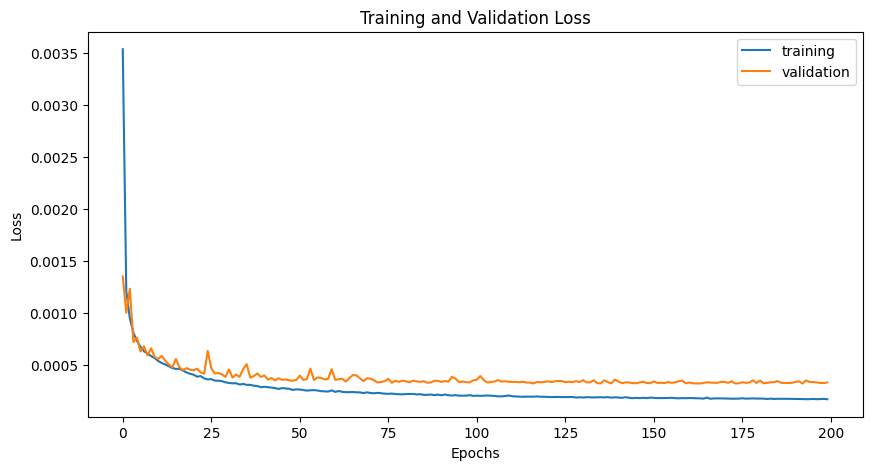

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F


# Initialize best metrics
best_val_loss = np.inf
best_val_mae = np.inf
# best_val_acc = 0.0

# Training loop
train_losses = []
train_maes = []
# train_accs = []

val_losses = []
val_maes = []
# val_accs = []

# Training loop
for epoch in range(epochs):
    # ... Training logic here ...
    model.train()
    train_loss = 0
    train_mae = 0
    # train_acc = 0

    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass and compute loss
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        # Calculate MAE
        mae = torch.nn.functional.l1_loss(outputs, targets, reduction='mean').item()
        train_mae += mae

        # # Calculate accuracy
        # acc = accuracy(outputs, targets)
        # train_acc += acc

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Train MAE: {train_mae/len(train_loader)}")

    train_losses.append(train_loss/len(train_loader))
    train_maes.append(train_mae/len(train_loader))
    # train_accs.append(train_acc/len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0
    val_mae = 0
    # val_acc = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Calculate MAE
            mae = torch.nn.functional.l1_loss(outputs, targets, reduction='mean').item()
            val_mae += mae

            # # Calculate accuracy
            # acc = accuracy(outputs, targets)
            # val_acc += acc

    print(f"Val Loss: {val_loss/len(val_loader)}, Val MAE: {val_mae/len(val_loader)}")

    val_losses.append(val_loss/len(val_loader))
    val_maes.append(val_mae/len(val_loader))
    # val_accs.append(val_acc/len(val_loader))

    # At the end of each epoch, check the validation metrics
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"/home/sodgala/Desktop/MIA_Project2/model/save_model_best_2C_FA/best_model_loss_epoch{epoch+1}.pth")
        print(f"New best model saved at epoch {epoch+1} with val_loss: {best_val_loss/len(val_loader)}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), f"/home/sodgala/Desktop/MIA_Project2/model/save_model_best_2C_FA/best_model_mae_epoch{epoch+1}.pth")
        print(f"New best model saved at epoch {epoch+1} with val_mae: {best_val_mae/len(val_loader)}")

    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     torch.save(model.state_dict(), f"/home/sodgala/Desktop/MIA_Project2/model/save_model_best_2C/best_model_acc_epoich{epoch+1}.pth")
    #     print(f"New best model saved at epoch {epoch+1} with val_acc: {best_val_acc}")



# Plot the Learning Curve
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="training")
plt.plot(val_losses, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## ADC

### Generate 2D image pairs input from T1w and T2w 3D images

In [ ]:
import numpy as np
import nibabel as nib
import glob
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import SimpleITK as sitk
import os
from torch.utils.data import Dataset, DataLoader

# ... existing data loading and processing code ...

import numpy as np
import nibabel as nib
import glob
from tqdm import tqdm
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import SimpleITK as sitk
import os

# Read and process the images 
# Source image pairs
dataset_path = '/home/sodgala/Desktop/MIA_Project2/RegisteredPaddedDataset/'
# dir_list_sc = sorted(glob.glob(dataset_path + '/MR_images_T1/train-pats/*nii.gz'))
dir_list_sc_t1 = sorted(glob.glob(os.path.join(dataset_path, '*', 'T1w_1mm_padded.nii.gz')))[:180]
dir_list_sc_t2 = sorted(glob.glob(os.path.join(dataset_path, '*', 'T2w_registered_padded.nii.gz')))[:180]
img_sc = image_proc_2C(dir_list_sc_t1, dir_list_sc_t2)

# Target images
# dir_list_tg = sorted(glob.glob(dataset_path + '/MR_images_T2/train-pats/*nii.gz'))
dir_list_tg = sorted(glob.glob(os.path.join(dataset_path, '*', 'ADC_registered_padded.nii.gz')))[:180]
img_tg = image_proc(dir_list_tg)

# Rearrange the axes
print(img_sc.shape)
print(img_tg.shape)
img_sc = np.transpose(img_sc, (0, 3, 1, 2))

img_tg = np.expand_dims(img_tg, -1)
img_tg = np.transpose(img_tg, (0, 3, 1, 2))
print(img_sc.shape)
print(img_tg.shape)

# img_sc = np.expand_dims(img_sc, -1)


# Split data to training and validation sets
x_train, x_test, y_train, y_test = train_test_split(img_sc.astype('float32'), img_tg.astype('float32'), test_size=0.20, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=1)

class MRIDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = MRIDataset(x_train, y_train)
val_dataset = MRIDataset(x_val, y_val)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Processing: 180it [00:41,  4.29it/s]
Processing:   1%|          | 2/180 [00:00<00:30,  5.90it/s]

(192, 224, 192)
(192, 224, 192)


Processing:   2%|▏         | 4/180 [00:00<00:22,  7.99it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:   4%|▍         | 8/180 [00:00<00:18,  9.38it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:   6%|▌         | 10/180 [00:01<00:17,  9.57it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:   8%|▊         | 14/180 [00:01<00:16,  9.97it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:   9%|▉         | 16/180 [00:01<00:16,  9.89it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  10%|█         | 18/180 [00:01<00:16,  9.75it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  12%|█▏        | 22/180 [00:02<00:15,  9.93it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  13%|█▎        | 24/180 [00:02<00:15, 10.10it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  15%|█▌        | 27/180 [00:02<00:15,  9.81it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  17%|█▋        | 30/180 [00:03<00:15,  9.96it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  18%|█▊        | 32/180 [00:03<00:15,  9.82it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  19%|█▉        | 34/180 [00:03<00:15,  9.55it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  21%|██        | 37/180 [00:03<00:14,  9.73it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  22%|██▏       | 40/180 [00:04<00:14,  9.97it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  23%|██▎       | 42/180 [00:04<00:14,  9.70it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  24%|██▍       | 44/180 [00:04<00:13,  9.81it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  26%|██▌       | 47/180 [00:04<00:13,  9.90it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  27%|██▋       | 49/180 [00:05<00:13,  9.86it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  29%|██▉       | 52/180 [00:05<00:12, 10.04it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  30%|███       | 54/180 [00:05<00:12,  9.83it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  32%|███▏      | 58/180 [00:06<00:12,  9.95it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  33%|███▎      | 60/180 [00:06<00:12,  9.94it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  35%|███▌      | 63/180 [00:06<00:11,  9.84it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  36%|███▌      | 65/180 [00:06<00:11,  9.69it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  37%|███▋      | 67/180 [00:06<00:11,  9.80it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  39%|███▉      | 70/180 [00:07<00:11,  9.74it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  41%|████      | 73/180 [00:07<00:10, 10.02it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  42%|████▏     | 75/180 [00:07<00:10, 10.13it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  43%|████▎     | 77/180 [00:07<00:10,  9.95it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  45%|████▌     | 81/180 [00:08<00:09, 10.11it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  46%|████▌     | 83/180 [00:08<00:09, 10.12it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  47%|████▋     | 85/180 [00:08<00:09, 10.05it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  49%|████▉     | 89/180 [00:09<00:09, 10.00it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  52%|█████▏    | 93/180 [00:09<00:08, 10.05it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  53%|█████▎    | 95/180 [00:09<00:08,  9.79it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  54%|█████▍    | 98/180 [00:10<00:08,  9.83it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  56%|█████▌    | 101/180 [00:10<00:07,  9.90it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  57%|█████▋    | 103/180 [00:10<00:07,  9.73it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  58%|█████▊    | 105/180 [00:10<00:07,  9.52it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  59%|█████▉    | 107/180 [00:10<00:07,  9.62it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  62%|██████▏   | 111/180 [00:11<00:07,  9.66it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  62%|██████▏   | 112/180 [00:11<00:07,  9.61it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  64%|██████▍   | 115/180 [00:11<00:06,  9.71it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  65%|██████▌   | 117/180 [00:12<00:06,  9.63it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  66%|██████▌   | 119/180 [00:12<00:06,  9.66it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  67%|██████▋   | 121/180 [00:12<00:06,  9.63it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  69%|██████▉   | 124/180 [00:12<00:05,  9.82it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  70%|███████   | 126/180 [00:12<00:05,  9.66it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  71%|███████   | 128/180 [00:13<00:05,  9.65it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  72%|███████▏  | 130/180 [00:13<00:05,  9.70it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  74%|███████▍  | 133/180 [00:13<00:04,  9.78it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  76%|███████▌  | 136/180 [00:13<00:04,  9.82it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  78%|███████▊  | 140/180 [00:14<00:03, 10.02it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  79%|███████▉  | 142/180 [00:14<00:03, 10.01it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  81%|████████  | 145/180 [00:14<00:03,  9.94it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  82%|████████▏ | 147/180 [00:15<00:03,  9.64it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  83%|████████▎ | 149/180 [00:15<00:03,  9.52it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  84%|████████▍ | 151/180 [00:15<00:03,  9.63it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  86%|████████▌ | 154/180 [00:15<00:02,  9.71it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  87%|████████▋ | 156/180 [00:16<00:02,  9.55it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  88%|████████▊ | 158/180 [00:16<00:02,  9.76it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  91%|█████████ | 163/180 [00:16<00:01,  9.85it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  92%|█████████▏| 166/180 [00:17<00:01,  9.95it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  93%|█████████▎| 168/180 [00:17<00:01,  9.96it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  94%|█████████▍| 170/180 [00:17<00:01,  9.71it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  96%|█████████▌| 172/180 [00:17<00:00,  9.95it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing:  97%|█████████▋| 174/180 [00:17<00:00, 10.04it/s]

(192, 224, 192)
(192, 224, 192)


Processing:  99%|█████████▉| 178/180 [00:18<00:00, 10.09it/s]

(192, 224, 192)
(192, 224, 192)
(192, 224, 192)


Processing: 100%|██████████| 180/180 [00:18<00:00,  9.76it/s]

(192, 224, 192)
(192, 224, 192)


(34560, 192, 224, 2)
(34560, 192, 224)
(34560, 2, 192, 224)
(34560, 1, 192, 224)


### Initialize UNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
import numpy as np
import time
import matplotlib.pyplot as plt

def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.ModuleList([
            conv_block(2, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            conv_block(64, 128)
        ])
        self.pool = nn.MaxPool2d(2)
        self.bridge = conv_block(128, 256)
        self.decoder = nn.ModuleList([
            conv_block(256, 128),
            conv_block(128, 64),
            conv_block(64, 32),
            conv_block(32, 16)
        ])
        self.upconv = nn.ModuleList([
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        ])
        self.final = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x)
            skips.append(x)
            x = self.pool(x)
        x = self.bridge(x)
        for i, layer in enumerate(self.decoder):
            x = self.upconv[i](x)
            x = torch.cat([x, skips[-(i+1)]], axis=1)
            x = layer(x)
        x = self.final(x)
        return x

# Print a summary of the model
model = UNet()
print(model)

# Training settings
epochs = 200
batch_size = 128
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
model.to(device)


UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64,

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64,

### Train and Validation

Epoch 1/200, Train Loss: 0.00017224788386341065, Train MAE: 0.009632600530594415
Val Loss: 5.074570799479261e-05, Val MAE: 0.004055093555838208
New best model saved at epoch 1 with val_loss: 5.074570799479261e-05
New best model saved at epoch 1 with val_mae: 0.004055093555838208
Epoch 2/200, Train Loss: 0.00012111234739787857, Train MAE: 0.008025457526724032
Val Loss: 3.011798340098308e-05, Val MAE: 0.002750332943502475
New best model saved at epoch 2 with val_loss: 3.011798340098308e-05
New best model saved at epoch 2 with val_mae: 0.002750332943502475
Epoch 3/200, Train Loss: 7.907193049120938e-05, Train MAE: 0.006497490286391035
Val Loss: 2.2039277444657106e-05, Val MAE: 0.002377657039852982
New best model saved at epoch 3 with val_loss: 2.2039277444657106e-05
New best model saved at epoch 3 with val_mae: 0.002377657039852982
Epoch 4/200, Train Loss: 5.90982526668443e-05, Train MAE: 0.0053077808007963995
Val Loss: 1.8347495328767266e-05, Val MAE: 0.0023924686829559505
New best model

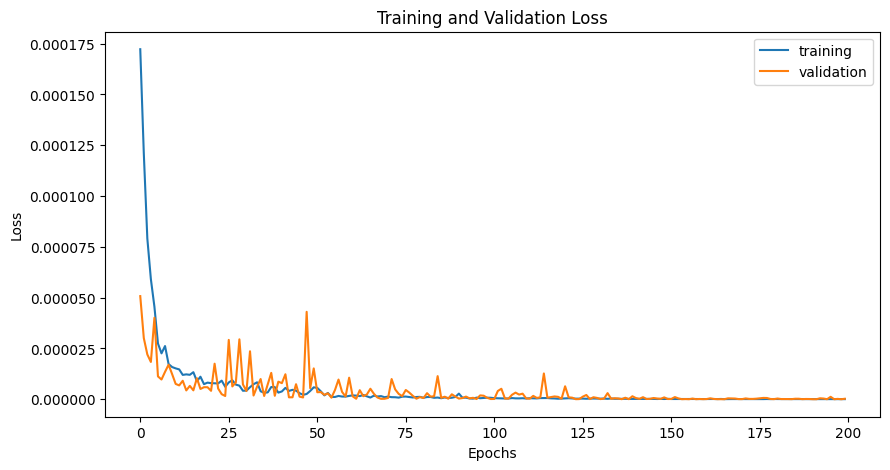

In [ ]:
import torch
import numpy as np
import torch.nn.functional as F


# Initialize best metrics
best_val_loss = np.inf
best_val_mae = np.inf
# best_val_acc = 0.0

# Training loop
train_losses = []
train_maes = []
# train_accs = []

val_losses = []
val_maes = []
# val_accs = []

# Training loop
for epoch in range(epochs):
    # ... Training logic here ...
    model.train()
    train_loss = 0
    train_mae = 0
    # train_acc = 0

    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass and compute loss
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        train_loss += loss.item()

        # Calculate MAE
        mae = torch.nn.functional.l1_loss(outputs, targets, reduction='mean').item()
        train_mae += mae

        # # Calculate accuracy
        # acc = accuracy(outputs, targets)
        # train_acc += acc

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Train MAE: {train_mae/len(train_loader)}")

    train_losses.append(train_loss/len(train_loader))
    train_maes.append(train_mae/len(train_loader))
    # train_accs.append(train_acc/len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0
    val_mae = 0
    # val_acc = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Calculate MAE
            mae = torch.nn.functional.l1_loss(outputs, targets, reduction='mean').item()
            val_mae += mae

            # # Calculate accuracy
            # acc = accuracy(outputs, targets)
            # val_acc += acc

    print(f"Val Loss: {val_loss/len(val_loader)}, Val MAE: {val_mae/len(val_loader)}")

    val_losses.append(val_loss/len(val_loader))
    val_maes.append(val_mae/len(val_loader))
    # val_accs.append(val_acc/len(val_loader))

    # At the end of each epoch, check the validation metrics
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f"/home/sodgala/Desktop/MIA_Project2/model/save_model_best_2C_ADC/best_model_loss_epoch{epoch+1}.pth")
        print(f"New best model saved at epoch {epoch+1} with val_loss: {best_val_loss/len(val_loader)}")

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        torch.save(model.state_dict(), f"/home/sodgala/Desktop/MIA_Project2/model/save_model_best_2C_ADC/best_model_mae_epoch{epoch+1}.pth")
        print(f"New best model saved at epoch {epoch+1} with val_mae: {best_val_mae/len(val_loader)}")

    # if val_acc > best_val_acc:
    #     best_val_acc = val_acc
    #     torch.save(model.state_dict(), f"/home/sodgala/Desktop/MIA_Project2/model/save_model_best_2C/best_model_acc_epoich{epoch+1}.pth")
    #     print(f"New best model saved at epoch {epoch+1} with val_acc: {best_val_acc}")



# Plot the Learning Curve
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(train_losses, label="training")
plt.plot(val_losses, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()